<h1>EDA</h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
matches = pd.read_csv("matches.csv")
deliveries = pd.read_csv("deliveries.csv", on_bad_lines='skip')

Matches Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1095 non-null   int64  
 1   season           1095 non-null   object 
 2   city             1044 non-null   object 
 3   date             1095 non-null   object 
 4   match_type       1095 non-null   object 
 5   player_of_match  1090 non-null   object 
 6   venue            1095 non-null   object 
 7   team1            1095 non-null   object 
 8   team2            1095 non-null   object 
 9   toss_winner      1095 non-null   object 
 10  toss_decision    1095 non-null   object 
 11  winner           1090 non-null   object 
 12  result           1095 non-null   object 
 13  result_margin    1076 non-null   float64
 14  target_runs      1092 non-null   float64
 15  target_overs     1092 non-null   float64
 16  super_over       1095 non-null   objec

<ipython-input-76-51e9b2e34e91>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  matches.fillna("Unknown", inplace=True)
<ipython-input-76-51e9b2e34e91>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=matches['winner'], order=matches['winner'].value_counts().index, palette="viridis")


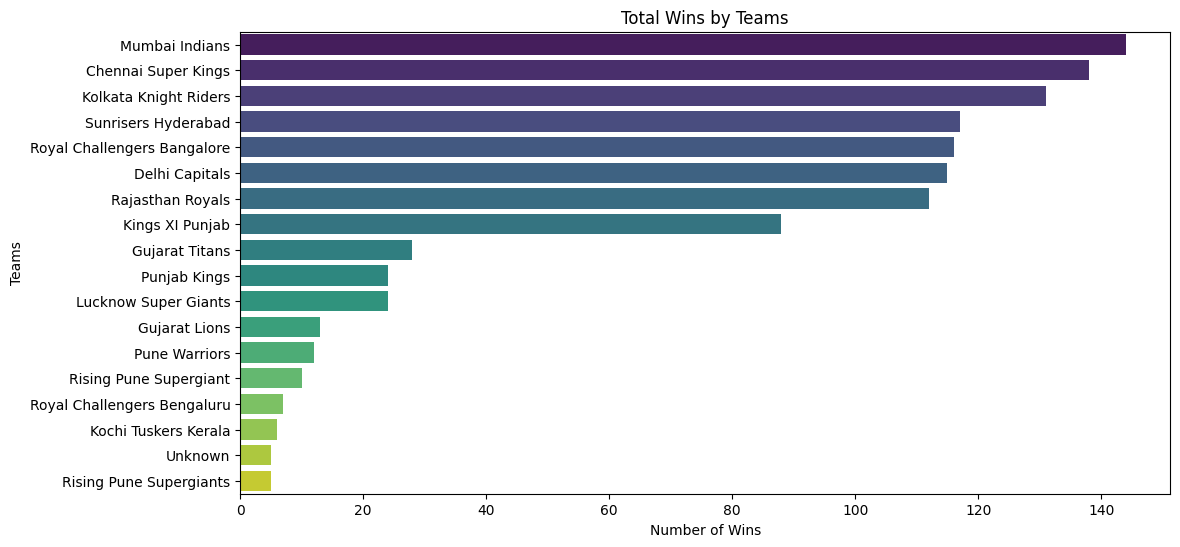

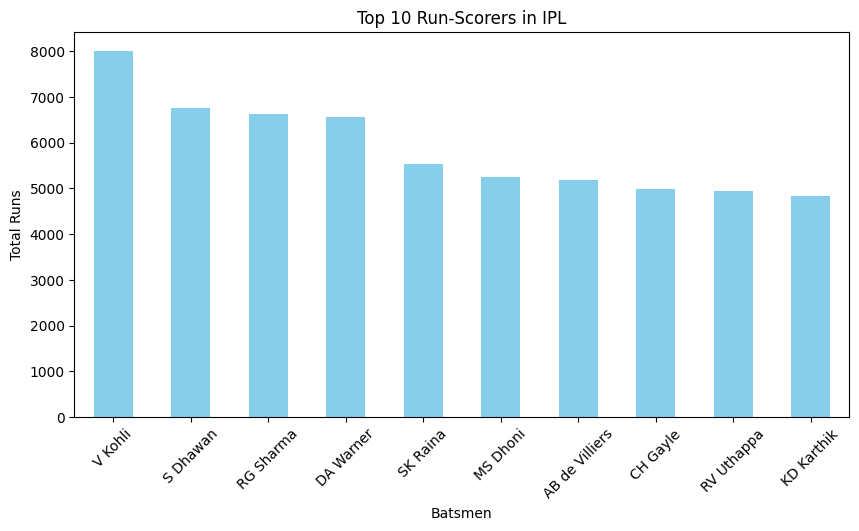

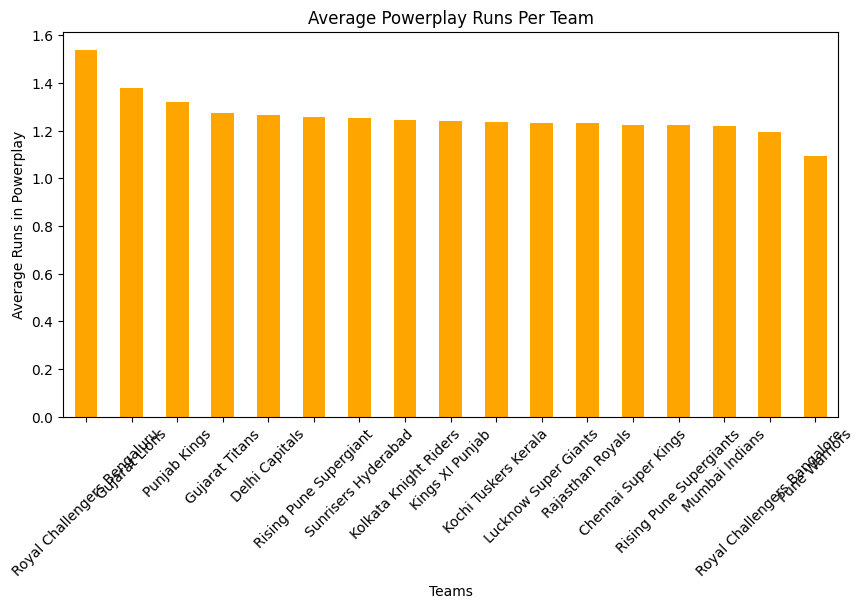

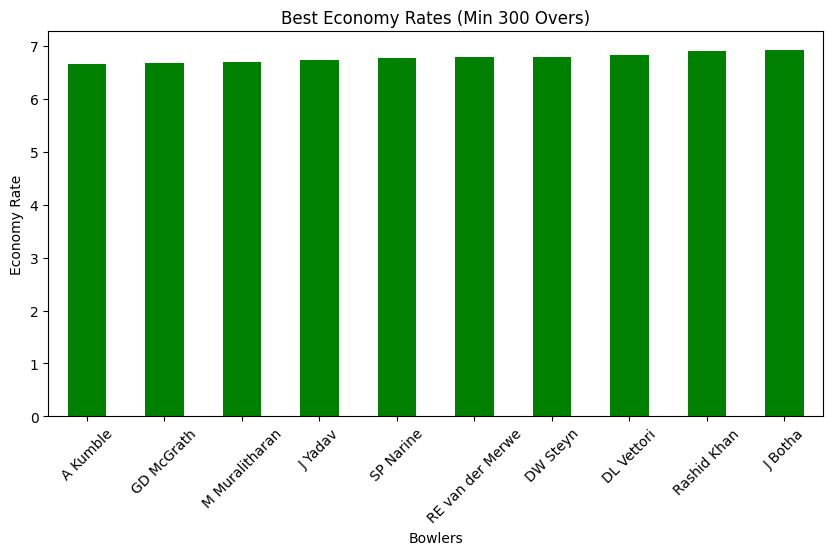

No matches with result margin ≥ 200 found.


In [ ]:
# Display basic info
print("Matches Dataset Info:")
print(matches.info())
print("\nDeliveries Dataset Info:")
print(deliveries.info())

# Check for missing values
print("\nMissing Values in Matches Dataset:")
print(matches.isnull().sum())

print("\nMissing Values in Deliveries Dataset:")
print(deliveries.isnull().sum())

# Handle missing values
matches.fillna("Unknown", inplace=True)
deliveries.fillna("Unknown", inplace=True)

# Drop duplicates
matches.drop_duplicates(inplace=True)
deliveries.drop_duplicates(inplace=True)

# Convert 'over' and 'total_runs' columns to numeric to avoid errors
deliveries['over'] = pd.to_numeric(deliveries['over'], errors='coerce')
deliveries['total_runs'] = pd.to_numeric(deliveries['total_runs'], errors='coerce')

# Remove rows with NaN values in 'over' or 'total_runs' columns
deliveries.dropna(subset=['over', 'total_runs'], inplace=True)

# Standardizing team names
team_corrections = {
    "Delhi Daredevils": "Delhi Capitals",
    "Deccan Chargers": "Sunrisers Hyderabad"
}

matches.replace({"team1": team_corrections, "team2": team_corrections, "winner": team_corrections}, inplace=True)
deliveries.replace({"batting_team": team_corrections, "bowling_team": team_corrections}, inplace=True)

# Exploratory Data Analysis
plt.figure(figsize=(12, 6))
sns.countplot(y=matches['winner'], order=matches['winner'].value_counts().index, palette="viridis")
plt.title("Total Wins by Teams")
plt.xlabel("Number of Wins")
plt.ylabel("Teams")
plt.show()

# Top 10 Run-Scorers
deliveries['batsman_runs'] = pd.to_numeric(deliveries['batsman_runs'], errors='coerce')

top_batsmen = deliveries.groupby('batter')['batsman_runs'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_batsmen.plot(kind='bar', color='skyblue')
plt.title("Top 10 Run-Scorers in IPL")
plt.xlabel("Batsmen")
plt.ylabel("Total Runs")
plt.xticks(rotation=45)
plt.show()

# Powerplay Analysis (overs 1-6)
powerplay_scores = deliveries[deliveries['over'] <= 6].groupby('batting_team')['total_runs'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
powerplay_scores.plot(kind='bar', color='orange')
plt.title("Average Powerplay Runs Per Team")
plt.xlabel("Teams")
plt.ylabel("Average Runs in Powerplay")
plt.xticks(rotation=45)
plt.show()

# Bowling Economy Rates
bowler_stats = deliveries.groupby('bowler').agg({'total_runs': 'sum', 'over': 'count'})
bowler_stats['economy_rate'] = bowler_stats['total_runs'] / (bowler_stats['over'] / 6)

best_economy_bowlers = bowler_stats[bowler_stats['over'] > 300].sort_values(by='economy_rate').head(10)
plt.figure(figsize=(10, 5))
best_economy_bowlers['economy_rate'].plot(kind='bar', color='green')
plt.title("Best Economy Rates (Min 300 Overs)")
plt.xlabel("Bowlers")
plt.ylabel("Economy Rate")
plt.xticks(rotation=45)
plt.show()

# 200+ Scores Per Season
matches['result_margin'] = pd.to_numeric(matches['result_margin'], errors='coerce')
matches['date'] = pd.to_datetime(matches['date'], errors='coerce')

high_scores = matches[matches['result_margin'] >= 200].groupby(matches['date'].dt.year).size()

if not high_scores.empty:
    plt.figure(figsize=(10, 5))
    high_scores.plot(kind='bar', color='purple')
    plt.title("Years with High Victory Margins (≥200 Runs)")
    plt.xlabel("Year")
    plt.ylabel("Number of Matches")
    plt.show()
else:
    print("No matches with result margin ≥ 200 found.")


<h1>Feature Engineering</h1>

In [ ]:
import pandas as pd

# Ensure 'date' column is in datetime format
matches['date'] = pd.to_datetime(matches['date'])

# Create 'season' feature
matches['season'] = matches['date'].dt.year

# Standardize team names BEFORE encoding
team_name_map = {
    'Royal Challengers Bengaluru': 'Royal Challengers Bangalore',
    'Punjab Kings': 'Kings XI Punjab',
    'Delhi Daredevils': 'Delhi Capitals',
    'Rising Pune Supergiants': 'Rising Pune Supergiant'
}

# Apply mapping on original columns
matches.replace({
    'team1': team_name_map,
    'team2': team_name_map,
    'toss_winner': team_name_map,
    'winner': team_name_map
}, inplace=True)

# Feature selection
features = matches[['season', 'team1', 'team2', 'toss_winner', 'toss_decision']]
target = matches['winner']

# One-hot encoding categorical variables
features = pd.get_dummies(features, columns=['team1', 'team2', 'toss_winner', 'toss_decision'])

# Save target categories for later decoding
target_categories = target.astype('category').cat.categories

# Convert target to categorical codes (numerical labels for ML models)
target = target.astype('category').cat.codes

# Create a dictionary mapping number to team name
team_list = {code: team for code, team in enumerate(target_categories)}

# Check the mapping
print("Team List Mapping: ", team_list)

Team List Mapping:  {0: 'Chennai Super Kings', 1: 'Delhi Capitals', 2: 'Gujarat Lions', 3: 'Gujarat Titans', 4: 'Kings XI Punjab', 5: 'Kochi Tuskers Kerala', 6: 'Kolkata Knight Riders', 7: 'Lucknow Super Giants', 8: 'Mumbai Indians', 9: 'Pune Warriors', 10: 'Rajasthan Royals', 11: 'Rising Pune Supergiant', 12: 'Royal Challengers Bangalore', 13: 'Sunrisers Hyderabad', 14: 'Unknown'}


<h1>Training</h1>

In [ ]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier

# Ensure target is categorical
target = target.astype('category')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

from imblearn.over_sampling import RandomOverSampler

# Initialize the oversampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Model Training
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced_subsample', random_state=42)

gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.05,
    objective='multi:softmax',  # For classification output
    num_class=len(y_train.cat.categories),  # Number of classes
    eval_metric='mlogloss',
    random_state=42
)

lgbm_optimized = LGBMClassifier(
    n_estimators=296,
    max_depth=19,
    learning_rate=0.021,
    num_leaves=22,
    colsample_bytree=0.581,
    subsample=0.632,
    random_state=42
)

# Fitting models
rf_model.fit(X_train_resampled, y_train_resampled)
gb_model.fit(X_train_resampled, y_train_resampled)
xgb_model.fit(X_train_resampled, y_train_resampled)
lgbm_optimized.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_optimized.predict(X_test)

results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gb), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_lgbm)]
})

print(results)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1860, number of used features: 46
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start train

<h1>Save Model<h1>

In [ ]:
import joblib
# Save Random Forest Model
joblib.dump(rf_model, 'random_forest_model.pkl')

# Save Gradient Boosting Model
joblib.dump(gb_model, 'gradient_boosting_model.pkl')

joblib.dump(xgb_model, 'xgradient_boosting_model.pkl')

joblib.dump(lgbm_optimized, 'lgradient_boosting_model.pkl')

print("Models saved successfully! 📊")

Models saved successfully! 📊


<h1>Predict</h1>

In [ ]:
import pandas as pd
from collections import Counter

# Ensure target is categorical
target = target.astype('category')
target_categories = list(target.cat.categories)  # Store the class labels

def predict_winner(season, team1, team2, toss_winner, toss_decision):
    # Prepare input data
    input_data = pd.DataFrame([[season, team1, team2, toss_winner, toss_decision]],
                              columns=['season', 'team1', 'team2', 'toss_winner', 'toss_decision'])

    # One-hot encode and align features
    input_data = pd.get_dummies(input_data)
    input_data = input_data.reindex(columns=features.columns, fill_value=0)  # Align with training features

    # Collect predictions from all models
    predictions = [
        rf_model.predict(input_data)[0],
        gb_model.predict(input_data)[0],
        xgb_model.predict(input_data)[0],
        lgbm_optimized.predict(input_data)[0]
    ]

    # Map model outputs back to team names
    model_outputs = [target_categories[pred] for pred in predictions]

    # Print individual model predictions (in team names)
    print(f"Random Forest Prediction: {team_list[model_outputs[0]]}")
    print(f"Gradient Boosting Prediction: {team_list[model_outputs[1]]}")
    print(f"XGBoost Prediction: {team_list[model_outputs[2]]}")
    print(f"LightGBM Prediction: {team_list[model_outputs[3]]}")

    # Perform Majority Voting (most frequent prediction wins)
    majority_vote = Counter(predictions).most_common(1)[0][0]

    # Decode the predicted label to team name
    predicted_winner = target_categories[majority_vote]

    print(f"\n🎯 Final Predicted Winner (by Voting): {team_list[predicted_winner]}")

# Example usage
season = 2025
team1 = "Sunrisers Hyderabad"
team2 = "Rajasthan Royals"
toss_winner = "Rajasthan Royals"
toss_decision = "field"

predict_winner(season, team1, team2, toss_winner, toss_decision)

Random Forest Prediction: Sunrisers Hyderabad
Gradient Boosting Prediction: Sunrisers Hyderabad
XGBoost Prediction: Rajasthan Royals
LightGBM Prediction: Sunrisers Hyderabad

🎯 Final Predicted Winner (by Voting): Sunrisers Hyderabad
